In [1]:
GLOVE_PATH = "C:\\Users\\Administrator\\Desktop\\glove\\glove.6B.100d.txt" # change to your path
EMBED_DIM = 100 # No need to change

In [2]:
from transformers import get_cosine_schedule_with_warmup
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.optim import AdamW
from torch.utils.data import DataLoader, Dataset 
import matplotlib as mpl
import matplotlib.pyplot as plt
from tensorflow import keras
import pandas as pd
import numpy as np
import random
from sklearn.metrics import confusion_matrix, f1_score, f1_score, roc_curve, auc, precision_recall_curve, average_precision_score
import seaborn as sns
from Embeddings import GloveEmbedding, GloveTokenizerNoSub
import itertools
import torch
from torch.utils.data import DataLoader
from typing import Any
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
import copy

In [3]:
# set seeds
def set_seed(seed):
    torch.manual_seed(seed)
    torch.cuda.manual_seed(seed)
    torch.cuda.manual_seed_all(seed)  # if you are using multi-GPU.
    np.random.seed(seed)
    random.seed(seed)
    torch.backends.cudnn.deterministic = True
    torch.backends.cudnn.benchmark = False
    
set_seed(114514)

In [4]:
# import tokenizer
tokenizer = GloveTokenizerNoSub(glove_file_path=GLOVE_PATH)
embedding = GloveEmbedding(
    glove_file_path = GLOVE_PATH, 
    trainable = False # False for part 2 to disable the Embedding training
)

In [5]:
class SentimentRNN(nn.Module):
    def __init__(self, embedding, hidden_size, embed_size, bidirectional, num_rnn_layer, dropout_rate, layer_norm):
        super(SentimentRNN, self).__init__()
        self.embedding = embedding  # pass pretrained embedding in
        self.bidirectional = bidirectional
        self.rnn = nn.RNN(embed_size, hidden_size, batch_first=True, num_layers = num_rnn_layer, bidirectional=bidirectional, dropout = dropout_rate if num_rnn_layer > 1 else 0)
        
        # if bidirectional, the output hidden size is double
        self.hidden_size = hidden_size * 2 if bidirectional else hidden_size
        
        # MLP
        if not layer_norm:
            self.output_layer = nn.Sequential(
                nn.Dropout(dropout_rate),
                nn.Linear(self.hidden_size, self.hidden_size),
                nn.GELU(),
                nn.Linear(self.hidden_size, 1),  # output dimension is 1 (sigmoid is in BCELossWithLogits, so no sigmoid here. This will get better result)
            )
        else:
            self.output_layer = nn.Sequential(
                nn.LayerNorm(self.hidden_size),
                nn.Dropout(dropout_rate),
                nn.Linear(self.hidden_size, self.hidden_size),
                nn.LayerNorm(self.hidden_size),
                nn.GELU(),
                nn.Linear(self.hidden_size, 1), 
            )
        
    def forward(self, input_ids, attention_mask):
        '''
        This method is designed for biLSTM/GRU/RNN. For LSTM/GRU/RNN for only one direction, just take hidden as the rnn output.
        RNN - hidden -> MLP --> outcome
        '''
        # embed the input
        embedded = self.embedding(input_ids)  # [batch_size, seq_length, embedding_dim]
        
        # feed forward
        output, hidden = self.rnn(embedded) # we don't need encoder so we only keep the output

        # make attention mask from [batch_size, seq_length] to [batch_size, seq_length, 1] as the same dimension as rnn
        attention_mask = attention_mask.unsqueeze(-1)  # [batch_size, seq_length, 1]

        # use attention mask to mask the output, ignore the padding embedding vector, only add the valid embedding vector 
        masked_output = output * attention_mask

        # sum up all the valid output
        summed_output = masked_output.sum(dim=1)  # [batch_size, hidden_size]

        logits = self.output_layer(summed_output)
        
        return logits  # The output is [batch_size, 1]




In [6]:
# import datasets

train_df = pd.read_csv("./preprocessed_dataset/train.csv").iloc[:,1:]
validation_df = pd.read_csv("./preprocessed_dataset/validation.csv").iloc[:,1:]
test_df = pd.read_csv("./preprocessed_dataset/test.csv").iloc[:,1:]

In [7]:
# try to use tokenizer api
tokenizer.encode(["hello world", "how are you"], return_tensors = "pt") # insist to return pytorch


{'input_ids': tensor([[13077,    87,     0],
         [  199,    34,    83]]),
 'attention_mask': tensor([[1, 1, 0],
         [1, 1, 1]])}

In [8]:
# Hyper paramaters
dropout_rate = 0.1
num_rnn_layer = 1
hidden_dim = 256

val_steps = 100 # compute validation error every n step

num_train_epochs = 3

batch_size = 32
lr = 1e-5
weight_decay = 1e-5


warmup_ratio=0.1
max_grad_norm = 1.0

In [9]:
# define dataset and data loader
class CustomizeDataset(Dataset):
    def __init__(
            self,
            df : pd.DataFrame
        ) -> None:
        super().__init__()
        self.df = df
        
    def __len__(self) -> int:
        return len(self.df)
    
    def __getitem__(
            self, 
            index : int
        ) -> dict:
        
        inputs = self.df.iloc[index,0] # 0 is text
        label = self.df.iloc[index, 1] # 1 is label
        
        return {
            "input_str" : inputs, # output a string
            "label" : label # output a label
        }
        
# collater function (used for dynamic padding to save memory)
class Collater:
    def __init__(
            self,
            tokenizer : GloveTokenizerNoSub
        ) -> None:
        self.tokenizer = tokenizer 
    
    def __call__(
            self,
            instances : list # a list of string
        ) -> Any:
        # __call__ is for function-like object
        input_str_list = [instance["input_str"] for instance in instances]
        input_dict = tokenizer.encode(input_str_list, return_tensors = "pt") # return pytorch tensor
        input_ids = input_dict["input_ids"]
        attention_mask = input_dict["attention_mask"]
        label = [torch.tensor(instance["label"], dtype = torch.int64) for instance in instances]

        return {
            "input_ids": input_ids,
            "label": torch.tensor(label),
            "attention_mask": attention_mask # mask the pad position
        }

In [10]:
# create dataset and data loader
collate_fn = Collater(tokenizer)



train_ds = CustomizeDataset(
    df = train_df
)

train_loader = DataLoader(
    dataset = train_ds,
    batch_size = batch_size,
    collate_fn = collate_fn,
    shuffle = True
)

val_ds = CustomizeDataset(
    df = validation_df
)

val_loader = DataLoader(
    dataset = val_ds,
    batch_size = batch_size,
    collate_fn = collate_fn
)

test_ds = CustomizeDataset(
    df = test_df
)

test_loader = DataLoader(
    dataset = test_ds,
    batch_size = batch_size,
    collate_fn = collate_fn
)

In [11]:
# compute warmup status
num_training_steps = num_train_epochs * len(train_loader)
num_warmup_steps = int(num_training_steps * warmup_ratio)
print(f"train:{num_training_steps}, warm up: {num_warmup_steps}")

train:801, warm up: 80


In [12]:
# Set optimizer, loss_fn and so on

cls_model = SentimentRNN(
    embedding = embedding, 
    hidden_size = hidden_dim, 
    embed_size = EMBED_DIM, 
    bidirectional = False, #  False for part 2
    num_rnn_layer = num_rnn_layer,
    dropout_rate = dropout_rate,
    layer_norm = True # set if you need layer norm
)

loss_fn = nn.BCEWithLogitsLoss()

optimizer = AdamW(
    params = cls_model.parameters(),
    lr = lr,
    weight_decay = weight_decay
)

scheduler  = get_cosine_schedule_with_warmup(
    optimizer = optimizer,
    num_warmup_steps = num_warmup_steps,
    num_training_steps = num_training_steps
)

In [13]:
# compute accuracy for wach data loader

def compute_accuracy(data_loader: DataLoader) -> float:
    
    cls_model.eval()
    
    correct = 0
    total = 0
    
    with torch.no_grad():
        for data in data_loader:
            input_ids = data["input_ids"].to(device)
            attention_mask = data["attention_mask"].to(device)
            labels = data["label"].view(-1, 1).float().to(device)
            
            logits = cls_model(input_ids, attention_mask=attention_mask)
     
            predictions = (logits > 0).long()
            
            correct += (predictions == labels).sum().item()
            total += labels.size(0)
    
    accuracy = correct / total
    return accuracy

def compute_loss(data_loader: DataLoader) -> float:
    total_loss = 0
    cls_model.eval()
    with torch.no_grad():
        for data in data_loader:
            input_ids = data["input_ids"].to(device)
            attention_mask = data["attention_mask"].to(device)
            labels = data["label"].view(-1, 1).float().to(device)
            
            logits = cls_model.forward(input_ids, attention_mask)
            loss = loss_fn.forward(
                input = logits,
                target = labels
            )
            
            total_loss += loss.detach().cpu()
            
        total_loss /= len(val_loader)
        
        return total_loss

In [14]:
def early_stopping(train_loss, validation_loss, min_delta, tolerance, counter):
    positive_diff = abs(validation_loss - train_loss)

    # Increment counter if no significant improvement
    if positive_diff >= min_delta:
        counter += 1
        if counter >= tolerance:
            return True, counter
    # Ensure the function always returns both values
    return False, counter

In [15]:
# Training loop

cls_model.to(device)

optimizer.zero_grad()

step = 0

train_losses = []

val_accs = []

val_losses = []

counter = 0

for epoch in range(num_train_epochs):
    
    # train loop
    for data in train_loader:
        cls_model.train()
        input_ids = data["input_ids"].to(device)
        attention_mask = data["attention_mask"].to(device)
        label = data["label"].view(-1, 1).float().to(device)
        
        logits = cls_model.forward(input_ids, attention_mask)
        
        
        loss = loss_fn.forward(
            input = logits,
            target = label
        )
        
        loss.backward()

        # Gradient clip (important for RNN, not necessary for LSTM/GRU/conv1d)
        torch.nn.utils.clip_grad_norm_(cls_model.parameters(), max_norm=max_grad_norm)
        
        optimizer.step() # update paramater
        scheduler.step() 
        optimizer.zero_grad() # clear gradient
        
        vis_loss = loss.detach().cpu()
        
        print(f"[{step + 1}/{num_training_steps}] train loss: [{vis_loss:.4f}] (epoch [{epoch + 1}/{num_train_epochs}])")
        
        
        train_losses.append(vis_loss)
        i =0 

        if (step + 1) % val_steps == 0 or step == 0:
            # compute validation every "val_steps"
           
            cls_model.eval()
            val_loss = compute_loss(val_loader)
            val_acc = compute_accuracy(val_loader)
            val_accs.append(val_acc)
            val_losses.append(val_loss)
            
            print(f"[{step + 1}/{num_training_steps}] validation loss: [{val_loss:.4f}] validation accuracy: [{val_acc:.4f}]")
            # Apply early stopping
            should_stop, counter = early_stopping(vis_loss, val_loss, min_delta=0.01, tolerance=10, counter=counter)
            if should_stop:
                print("Early stopping triggered.")
                break
        
        step += 1
        
    if should_stop:
        break  # Exit e


[1/801] train loss: [0.7464] (epoch [1/3])
[1/801] validation loss: [0.7005] validation accuracy: [0.4981]
[2/801] train loss: [0.7313] (epoch [1/3])
[3/801] train loss: [0.7327] (epoch [1/3])
[4/801] train loss: [0.7324] (epoch [1/3])
[5/801] train loss: [0.6955] (epoch [1/3])
[6/801] train loss: [0.7363] (epoch [1/3])
[7/801] train loss: [0.6552] (epoch [1/3])
[8/801] train loss: [0.7138] (epoch [1/3])
[9/801] train loss: [0.6937] (epoch [1/3])
[10/801] train loss: [0.7431] (epoch [1/3])
[11/801] train loss: [0.6925] (epoch [1/3])
[12/801] train loss: [0.6734] (epoch [1/3])
[13/801] train loss: [0.7420] (epoch [1/3])
[14/801] train loss: [0.7007] (epoch [1/3])
[15/801] train loss: [0.6805] (epoch [1/3])
[16/801] train loss: [0.6988] (epoch [1/3])
[17/801] train loss: [0.7665] (epoch [1/3])
[18/801] train loss: [0.6718] (epoch [1/3])
[19/801] train loss: [0.7074] (epoch [1/3])
[20/801] train loss: [0.7053] (epoch [1/3])
[21/801] train loss: [0.6874] (epoch [1/3])
[22/801] train loss: 

In [16]:
# Test the model
# Define hyperparameter ranges
param_grid = {
    "num_rnn_layer": range(1, 2),  # Integer range for number of RNN layers
    "hidden_dim": [128, 256],  # Integer range for hidden dimension size
    "dropout_rate": [0.1, 0.2],  # Continuous range for dropout rate
    "learning_rate": [1e-4, 1e-3],  # Continuous range for learning rate
    "batch_size": [128, 256],  # Integer range for batch size
    "max_grad_norm": [1.0, 2.0],  # Continuous range for gradient clipping
    "num_train_epochs": [1,2,3]  # Integer range for number of training epochs
}

# Track the best configuration
best_val_loss = float('inf')
best_val_accuracy = 0.0
best_params = None

# Generate all combinations of hyperparameters
for params in itertools.product(
    param_grid["num_rnn_layer"],
    param_grid["hidden_dim"],
    param_grid["dropout_rate"],
    param_grid["learning_rate"],
    param_grid["batch_size"],
    param_grid["max_grad_norm"],
    param_grid["num_train_epochs"]
):
    # Unpack hyperparameters
    num_rnn_layer, hidden_dim, dropout_rate, learning_rate, batch_size, max_grad_norm, num_train_epochs = params
    
    # Initialize model with current parameters
    cls_model = SentimentRNN(
        embedding=embedding,
        hidden_size=hidden_dim,
        embed_size=EMBED_DIM,
        bidirectional=False,
        num_rnn_layer=num_rnn_layer,
        dropout_rate=dropout_rate,
        layer_norm=True
    ).to(device)
    
    # Set up optimizer and scheduler
    optimizer = torch.optim.Adam(cls_model.parameters(), lr=learning_rate)
    scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=1, gamma=0.9)
    
    # DataLoader for selected batch size
    train_loader = DataLoader(
        dataset=train_ds,
        batch_size=batch_size,
        collate_fn=collate_fn,
        shuffle=True
    )
    
    # Early stopping and metrics tracking variables
    counter = 0
    step = 0
    train_losses = []
    val_losses = []
    val_accs = []
    should_stop = False
    early_stopped = False  # Flag to indicate early stopping for this trial
    
    for epoch in range(num_train_epochs):
        # Training loop
        for data in train_loader:
            cls_model.train()
            input_ids = data["input_ids"].to(device)
            attention_mask = data["attention_mask"].to(device)
            label = data["label"].view(-1, 1).float().to(device)
            
            logits = cls_model(input_ids, attention_mask)
            
            loss = loss_fn(input=logits, target=label)
            loss.backward()

            # Gradient clipping
            torch.nn.utils.clip_grad_norm_(cls_model.parameters(), max_norm=max_grad_norm)
            
            optimizer.step()
            scheduler.step()
            optimizer.zero_grad()
            
            vis_loss = loss.detach().cpu().item()
            train_losses.append(vis_loss)
            
            # Validation step every `val_steps`
            if (step + 1) % val_steps == 0 or step == 0:
                cls_model.eval()
                val_loss = compute_loss(val_loader)
                val_acc = compute_accuracy(val_loader)
                val_losses.append(val_loss)
                val_accs.append(val_acc)
                
                # Early stopping check
                should_stop, counter = early_stopping(vis_loss, val_loss, min_delta=0.5, tolerance=2, counter=counter)
                if should_stop:
                    print("Early stopping triggered.")
                    early_stopped = True  # Mark this trial as early stopped
                    break

            step += 1
        
        if should_stop:
            break  # Exit epoch loop if early stopping is triggered

    # Track the best parameters and validation loss
    current_val_accuracy = val_accs[-1] if val_accs else 0.0
    #current_val_loss = val_loss[-1] if val_loss else 0.0
    if current_val_accuracy > best_val_accuracy and early_stopped==False:
        #best_val_loss = current_val_loss
        best_val_accuracy = current_val_accuracy
        best_params = params
    
    # Print the trial's results, including early stopping info
    print(f"Trial with params: {params}")
    #print(f"  Validation Loss: {current_val_loss}")
    print(f"  Validation Accuracy: {current_val_accuracy}")
    if early_stopped:
        print("  Early stopped")
    

# Print the best result
print("Best result:")
print(f"  Validation Loss: {best_val_loss}")
print(f"  Validation Accuracy: {best_val_accuracy}")
print("  Best hyperparameters:", best_params)



Trial with params: (1, 128, 0.1, 0.0001, 128, 1.0, 1)
  Validation Accuracy: 0.4971857410881801
Trial with params: (1, 128, 0.1, 0.0001, 128, 1.0, 2)
  Validation Accuracy: 0.574108818011257
Trial with params: (1, 128, 0.1, 0.0001, 128, 1.0, 3)
  Validation Accuracy: 0.5318949343339587
Trial with params: (1, 128, 0.1, 0.0001, 128, 2.0, 1)
  Validation Accuracy: 0.49530956848030017
Trial with params: (1, 128, 0.1, 0.0001, 128, 2.0, 2)
  Validation Accuracy: 0.5534709193245778
Trial with params: (1, 128, 0.1, 0.0001, 128, 2.0, 3)
  Validation Accuracy: 0.5844277673545967
Trial with params: (1, 128, 0.1, 0.0001, 256, 1.0, 1)
  Validation Accuracy: 0.5619136960600375
Trial with params: (1, 128, 0.1, 0.0001, 256, 1.0, 2)
  Validation Accuracy: 0.5056285178236398
Trial with params: (1, 128, 0.1, 0.0001, 256, 1.0, 3)
  Validation Accuracy: 0.5684803001876173
Trial with params: (1, 128, 0.1, 0.0001, 256, 2.0, 1)
  Validation Accuracy: 0.4831144465290807
Trial with params: (1, 128, 0.1, 0.0001,

In [17]:
##(1, 128, 0.1, 0.001, 256, 2.0, 3) --> higest accuracy
print(best_params)

(1, 256, 0.1, 0.001, 128, 1.0, 2)


In [18]:
val_steps = 100
batch_size = 256
dropout_rate = 0.1
hidden_dim = 128
learning_rate = 0.001
num_rnn_layer = 1
max_grad_norm = 2.0
num_train_epochs = 3

num_training_steps = num_train_epochs * len(train_loader)
num_warmup_steps = int(num_training_steps * warmup_ratio)
print(f"train:{num_training_steps}, warm up: {num_warmup_steps}")

train:102, warm up: 10


In [19]:
cls_model = SentimentRNN(
    embedding=embedding,
    hidden_size=hidden_dim,
    embed_size=EMBED_DIM,
    bidirectional=False,  # False for part 2
    num_rnn_layer=num_rnn_layer,
    dropout_rate=dropout_rate,
    layer_norm=True
).to(device)
# Set up optimizer and scheduler
optimizer = torch.optim.Adam(cls_model.parameters(), lr=learning_rate)
scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=1, gamma=0.9)

train_loader = DataLoader(
    dataset=train_ds,
    batch_size=batch_size,
    collate_fn=collate_fn,
    shuffle=True
)

optimizer.zero_grad()

step = 0

train_losses = []

val_accs = []

val_losses = []

counter = 0

for epoch in range(num_train_epochs):
    
    # train loop
    for data in train_loader:
        cls_model.train()
        input_ids = data["input_ids"].to(device)
        attention_mask = data["attention_mask"].to(device)
        label = data["label"].view(-1, 1).float().to(device)
        
        logits = cls_model.forward(input_ids, attention_mask)
        
        
        loss = loss_fn.forward(
            input = logits,
            target = label
        )
        
        loss.backward()

        # Gradient clip (important for RNN, not necessary for LSTM/GRU/conv1d)
        torch.nn.utils.clip_grad_norm_(cls_model.parameters(), max_norm=max_grad_norm)
        
        optimizer.step() # update paramater
        scheduler.step() 
        optimizer.zero_grad() # clear gradient
        
        vis_loss = loss.detach().cpu()
        
        print(f"[{step + 1}/{num_training_steps}] train loss: [{vis_loss:.4f}] (epoch [{epoch + 1}/{num_train_epochs}])")
        
        
        train_losses.append(vis_loss)
        i =0 

        if (step + 1) % val_steps == 0 or step == 0:
            # compute validation every "val_steps"
           
            cls_model.eval()
            val_loss = compute_loss(val_loader)
            val_acc = compute_accuracy(val_loader)
            val_accs.append(val_acc)
            val_losses.append(val_loss)
            
            print(f"[{step + 1}/{num_training_steps}] validation loss: [{val_loss:.4f}] validation accuracy: [{val_acc:.4f}]")
            # Apply early stopping
            should_stop, counter = early_stopping(vis_loss, val_loss, min_delta=0.01, tolerance=2, counter=counter)
            if should_stop:
                print("Early stopping triggered.")
                break
        
        step += 1
        
    if should_stop:
        break  # Exit e

[1/102] train loss: [0.6938] (epoch [1/3])
[1/102] validation loss: [0.7427] validation accuracy: [0.4991]
[2/102] train loss: [0.7514] (epoch [1/3])
[3/102] train loss: [0.6731] (epoch [1/3])
[4/102] train loss: [0.6842] (epoch [1/3])
[5/102] train loss: [0.6906] (epoch [1/3])
[6/102] train loss: [0.6700] (epoch [1/3])
[7/102] train loss: [0.6812] (epoch [1/3])
[8/102] train loss: [0.6766] (epoch [1/3])
[9/102] train loss: [0.6708] (epoch [1/3])
[10/102] train loss: [0.6675] (epoch [1/3])
[11/102] train loss: [0.6595] (epoch [1/3])
[12/102] train loss: [0.6595] (epoch [1/3])
[13/102] train loss: [0.6615] (epoch [1/3])
[14/102] train loss: [0.6698] (epoch [1/3])
[15/102] train loss: [0.6593] (epoch [1/3])
[16/102] train loss: [0.6671] (epoch [1/3])
[17/102] train loss: [0.6610] (epoch [1/3])
[18/102] train loss: [0.6610] (epoch [1/3])
[19/102] train loss: [0.6629] (epoch [1/3])
[20/102] train loss: [0.6516] (epoch [1/3])
[21/102] train loss: [0.6525] (epoch [1/3])
[22/102] train loss: 

In [20]:
train_loss = compute_loss(train_loader)
train_acc = compute_accuracy(train_loader)
test_loss = compute_loss(test_loader)
test_acc = compute_accuracy(test_loader)
val_loss = compute_loss(val_loader)
test_acc = compute_accuracy(test_loader)

print(f"Train Loss: [{train_loss:.4f}]\nTrain accuracy: [{train_acc:.4f}]")
print(f"Test Loss: [{test_loss:.4f}]\nTest accuracy: [{test_acc:.4f}]")
print(f"Validation Loss: [{val_loss:.4f}]\nValidation accuracy: [{val_acc:.4f}]")

Train Loss: [0.6324]
Train accuracy: [0.6547]
Test Loss: [0.6369]
Test accuracy: [0.6388]
Validation Loss: [0.6403]
Validation accuracy: [0.6567]


In [21]:
# compute predictions and labels for confusion matrix computing
def compute_pedictions_and_labels(
        model : nn.Module, 
        test_loader : DataLoader, 
        device : torch.device
    ) -> tuple:
    
    model.to(device)
    
    model.eval()
    
    # Lists to store all predictions and actual labels
    all_predictions = []
    all_labels = []
    
    with torch.no_grad():
        for data in test_loader:
            input_ids = data["input_ids"].to(device)
            attention_mask = data["attention_mask"].to(device)
            labels = data["label"].view(-1, 1).float().to(device)
            
            logits = model(input_ids, attention_mask=attention_mask)
     
            predictions = (logits > 0).long()
            
            all_predictions.extend(predictions.view(-1).cpu().numpy())
            all_labels.extend(labels.view(-1).cpu().numpy())
    
    return all_predictions, all_labels

all_predictions, all_labels = compute_pedictions_and_labels(cls_model, test_loader, device)

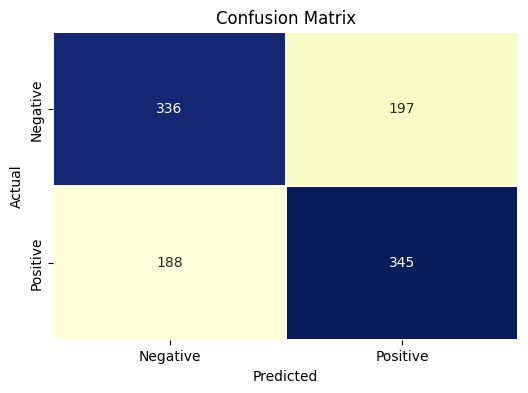

In [22]:
# visualization 2: confusion matrix

def plot_confusion(
        all_predictions : list, 
        all_labels : list
    ) -> None:      
            
    cm = confusion_matrix(all_labels, all_predictions) # from sklearn
            
    plt.figure(figsize=(6,4))
    sns.heatmap(cm, annot=True, fmt='d', linewidths=0.2, cmap="YlGnBu", cbar=False)
    plt.xlabel("Predicted")
    plt.ylabel("Actual")
    plt.title("Confusion Matrix")
    plt.xticks([0.5, 1.5], ['Negative', 'Positive'])
    plt.yticks([0.5, 1.5], ['Negative', 'Positive'], va='center')
    plt.show()
    
plot_confusion(all_predictions, all_labels)